In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib
from astropy.table import Table

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

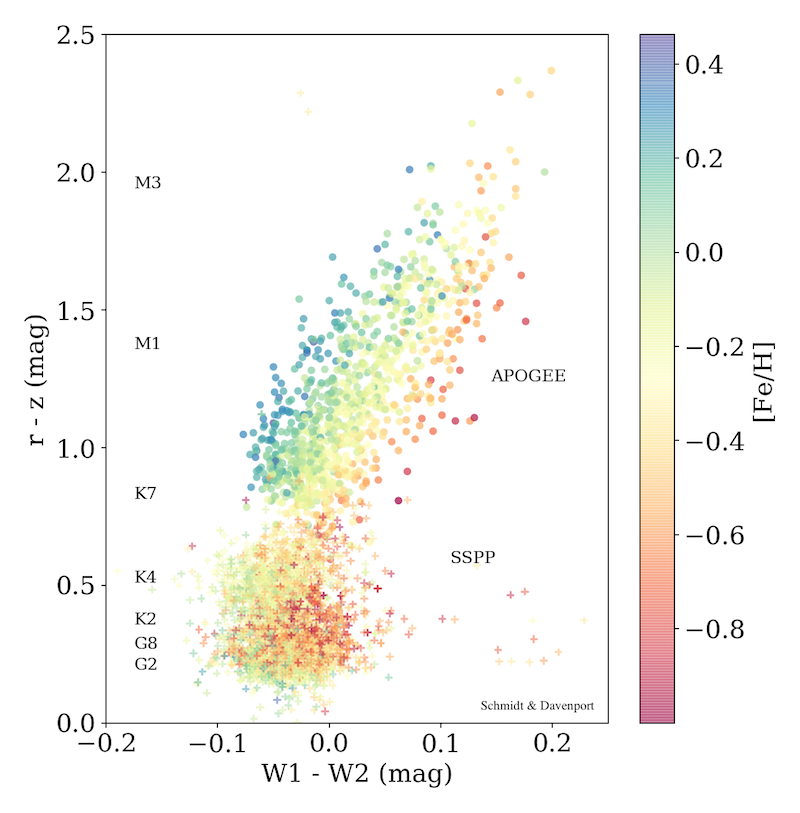

In [3]:
from IPython.display import Image
Image(filename='./w1w2_rz_feh.png', width=500) 

In [16]:
k2_file = '/Users/james/Desktop/gaia_tmp/k2_dr2_1arcsec.fits'
k2 = Table.read(k2_file, format='fits')

In [17]:
df = k2.to_pandas()

In [18]:
dfnew = pd.DataFrame(data={'ra':df['ra'], 'dec':df['dec']})

dfnew.to_csv('to_X.csv', columns=('ra', 'dec'), index_label=False, index=False)

In [19]:
k2.colnames

['designation',
 'source_id',
 'gaia_ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_primary_flag',
 'duplicated_source',
 'phot_g_mean_flux',
 'phot_g_mean_flux_error',
 'phot_g_mean_mag',
 'phot_bp_mean_flux',
 'phot_bp_mean_flux_error',
 'phot_bp_mean_mag',
 'phot_rp_mean_flux',
 'phot_rp_mean_flux_error',
 'phot_rp_mean_mag',
 'bp_rp',
 'bp_g',
 'g_rp',
 'radial_velocity',
 'radial_velocity_error',
 'phot_variable_flag',
 'l',
 'b',
 'ecl_lon',
 'ecl_lat',
 'teff_val',
 'teff_percentile_lower',
 'teff_percentile_upper',
 'a_g_val',
 'a_g_percentile_lower',
 'a_g_percentile_upper'